In [1]:
"""
From the confusion matrix, we are given the following:
TP = 255
FP = 1380
FN = 45
TN = 20
"""

# precsion  = TP/TP + FP 

precision = 255/(255 + 1380)

# Calculate Recall  TP/(TP + FN)
recall = 255/(255 + 45)

# compute the F1 score
f1 = 2*(precision*recall)/(precision + recall)

print(f1)

0.2635658914728682


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost, lightgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv(r'C:\filestore_PP\Data_for_UCI_named.csv')
df.head(3)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable


In [4]:
df.stabf.value_counts()

unstable    6380
stable      3620
Name: stabf, dtype: int64

In [5]:
# Split the dataset
X = df.drop(columns=['stab', 'stabf'])
y = df['stabf']

In [6]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [7]:
# Scale the data with Standard Scaler
scale = StandardScaler()
scaled_x_train = pd.DataFrame(scale.fit_transform(X_train), columns=(X_train.columns))
scaled_x_test = pd.DataFrame(scale.fit_transform(X_test), columns=(X_test.columns))

In [8]:
rf = RandomForestClassifier(random_state = 1)
rf.fit(scaled_x_train, y_train)
rf_pred = rf.predict(scaled_x_test)
print(f'Accuracy score of RandomForestClassifier in 4 decimal places is {round(accuracy_score(y_test, rf_pred), 4)}')

Accuracy score of RandomForestClassifier in 4 decimal places is 0.928


In [9]:
xgb = XGBClassifier(random_state = 1)
xgb.fit(scaled_x_train, y_train)
xgb_pred = xgb.predict(scaled_x_test)
print(f'Accuracy score of XGBClassifier in 4 decimal places is {round(accuracy_score(y_test, xgb_pred), 4)}')

Accuracy score of XGBClassifier in 4 decimal places is 0.919

In [10]:
lgc = LGBMClassifier(random_state=1)
lgc.fit(scaled_x_train, y_train)
lgc_pred = lgc.predict(scaled_x_test)
print(f'Accuracy score of LGBMClassifier in 4 decimal places is {round(accuracy_score(y_test, lgc_pred), 4)}')

Accuracy score of LGBMClassifier in 4 decimal places is 0.9365


In [11]:
n_estimators = [100, 300, 500, 1000]

min_samples_split = [2, 5, 7, 9]

min_samples_leaf = [2, 4, 6, 8]

max_features = ['auto', 'sqrt', 'log2', None] 

# Define the param grid
hyperparameter_grid = {'n_estimators': n_estimators,

                       'min_samples_leaf': min_samples_leaf,

                       'min_samples_split': min_samples_split,

                       'max_features': max_features}


ext = ExtraTreesClassifier()
# instantiate the gridsearch
randomised_search = RandomizedSearchCV(ext, param_distributions= hyperparameter_grid,
                                       scoring='accuracy',
                                       n_iter=10,
                                       cv=5,
                                       n_jobs=-1,
                                       verbose=1,
                                       random_state=1)

# fit the grid with training set
randomised_search.fit(scaled_x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 7, 9],
                                        'n_estimators': [100, 300, 500, 1000]},
                   random_state=1, scoring='accuracy', verbose=1)

In [12]:
# Get the best hyperparameters
randomised_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 7,
 'min_samples_leaf': 4,
 'max_features': None}

In [13]:
# Compute the old accuracy
ext.fit(scaled_x_train, y_train)

old_acc_score = round(accuracy_score(y_test, ext.predict(scaled_x_test)), 4)
print(f'old accuracy score is {old_acc_score}')

print('............................................................................................................')

# Get the model with new hyperparameters from the randomsearchcv
rand_for = randomised_search.best_estimator_

# Train a new ExtraTree model with new hyparameters
rand_for.fit(scaled_x_train, y_train)

# make new predictions
new_p = rand_for.predict(scaled_x_test)

# Compute new accuracy score
print(f'New Accuracy score is {round(accuracy_score(y_test, new_p), 4)}')

old accuracy score is 0.9285
............................................................................................................
New Accuracy score is 0.926


Text(0.5, 1.0, 'Feature Importance')

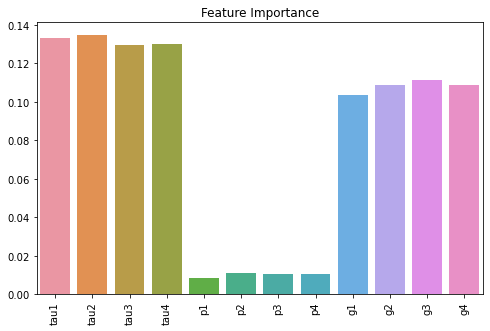

In [14]:
feature_importance = rand_for.feature_importances_
feature_dict = dict(zip(X.columns, list(feature_importance)))

plt.figure(figsize=(8,5))
plt.xticks(rotation = 90)

feature_import_df = pd.DataFrame(feature_dict, index=[0])

sns.barplot(data=feature_import_df)
plt.title("Feature Importance")
